in this example, we use a encoder-decoder network to colorize gray images.
first, we convert colorful RGB images into LAB space. we use L channel as networks's input.
and we use A and B channels as outputs. A and B contain the color information in LAB space.
then by combining L,A,B channels we can reconstruct the colorful image.
dataset from: http://efrosgans.eecs.berkeley.edu/cyclegan/datasets/horse2zebra.zip

In [1]:
import tensorflow as tf
import numpy as np
from matplotlib import pyplot as plt
from pathlib import Path
from sklearn.model_selection import train_test_split
import tensorflow_io as tfio
from tensorflow.keras.layers import Input, Conv2D, UpSampling2D, MaxPooling2D, Concatenate

In [2]:
ds_path = "../datasets/horse2zebra" # enter path to the dataset
image_size = 128 # enter image size
batch_size = 32 # enter batch size
all_img_path = [str(p) for p in Path(ds_path).rglob('*.jpg')]
train_path, test_path = train_test_split(all_img_path, test_size=0.2, shuffle=True, random_state=42)

In [3]:
# function to load images and seperate the gray and color channel. this function will be used in tensorflow data pipeline.
def load_and_preprocess_images(impath):
    im = tf.io.read_file(impath)
    colorimg = tf.image.decode_image(im, channels=3)
    colorimg = tf.image.resize_with_pad(colorimg, target_height=image_size, target_width=image_size)
    colorimg = tf.cast(colorimg, dtype=tf.float32) / 255.0
    
    labimg = tfio.experimental.color.rgb_to_lab(colorimg)
    graypart = tf.expand_dims(labimg[...,0], axis=-1) / 100
    colorpart = labimg[...,1:] / 128
    
    return graypart, colorpart

In [4]:
# standard data pipeline for train and test dataset
ds_train = tf.data.Dataset.from_tensor_slices(train_path)
ds_train = ds_train.map(load_and_preprocess_images, num_parallel_calls=tf.data.AUTOTUNE)
ds_train = ds_train.cache()
ds_train = ds_train.shuffle(len(ds_train), seed=42, reshuffle_each_iteration=False)
ds_train = ds_train.batch(batch_size)
ds_train = ds_train.prefetch(tf.data.AUTOTUNE)

ds_test = tf.data.Dataset.from_tensor_slices(test_path)
ds_test = ds_test.map(load_and_preprocess_images, num_parallel_calls=tf.data.AUTOTUNE)
ds_test = ds_test.cache()
ds_test = ds_test.batch(batch_size)
ds_test = ds_test.prefetch(tf.data.AUTOTUNE)

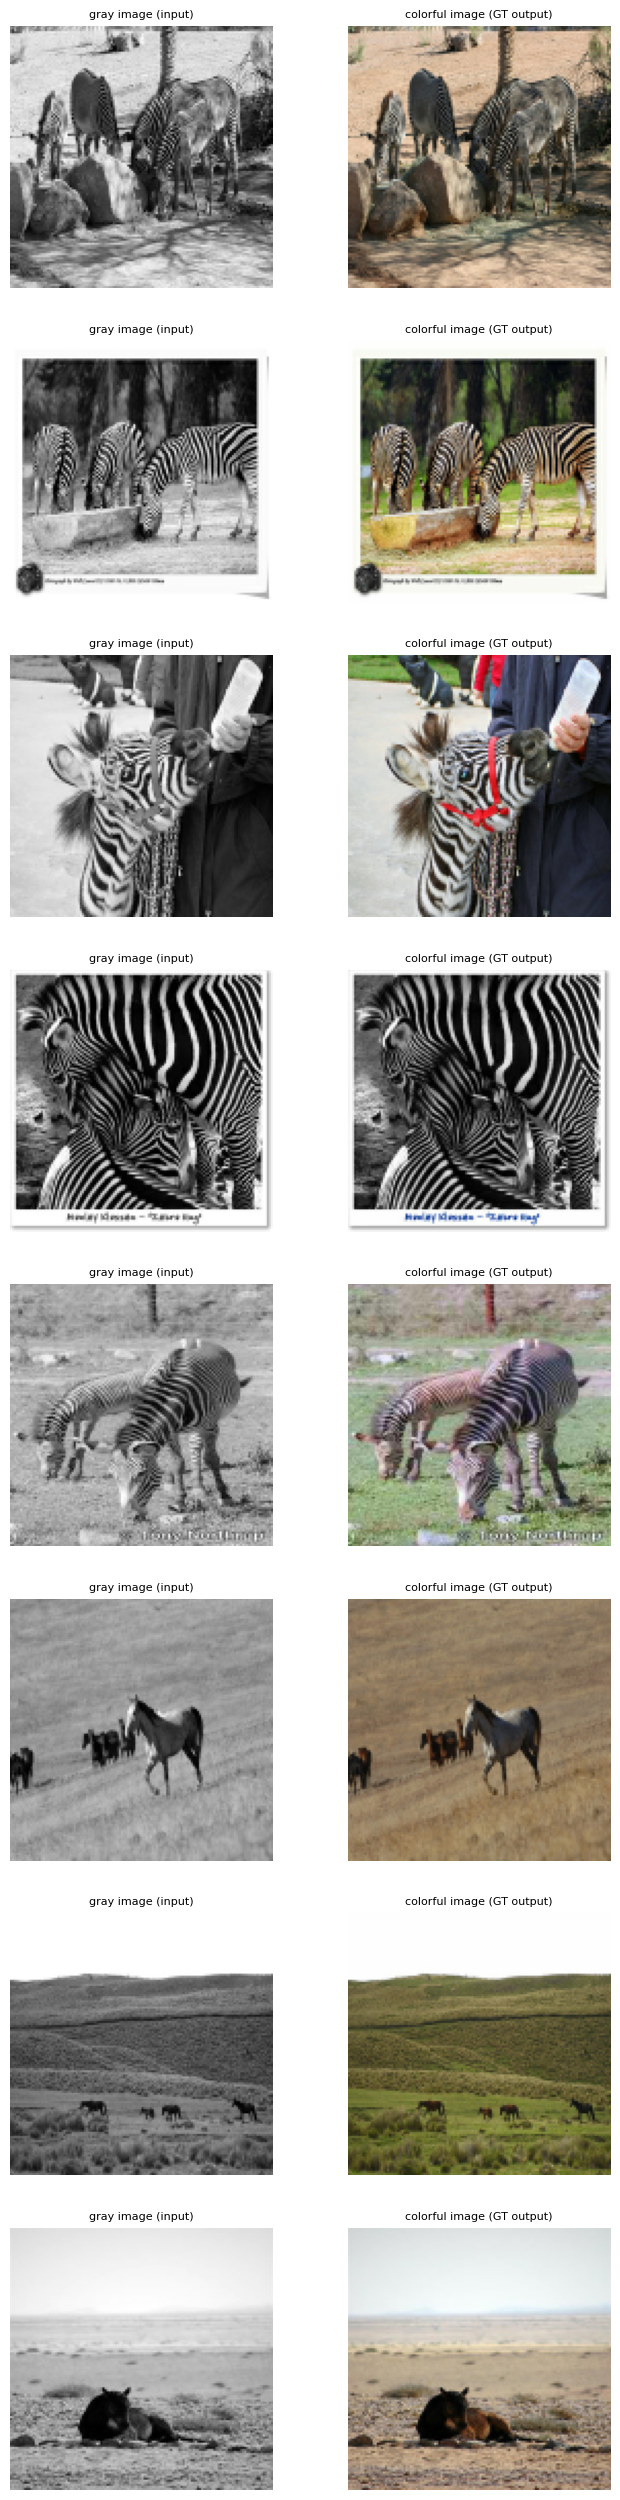

In [5]:
# show a sample gray image and its colorful correspondence.
sample_input, sample_output = list(ds_train.as_numpy_iterator())[0]
grayimg = sample_input
colorimg = tfio.experimental.color.lab_to_rgb(np.concatenate((100*grayimg,128*sample_output), axis=-1)).numpy()
fig, axs = plt.subplots(8, 2, figsize=(8,32))
for i in range(8):
    axs[i,0].imshow(grayimg[i,...], cmap='gray')
    axs[i,1].imshow(colorimg[i,...])
    axs[i,0].axis('off')
    axs[i,1].axis('off')
    axs[i,0].set_title('gray image (input)', size=8)
    axs[i,1].set_title('colorful image (GT output)', size=8)
plt.show()

In [6]:
# define auto encoder-decoder network
def define_model():
    model = tf.keras.models.Sequential()

    # encoder
    model.add(Input(shape=(image_size, image_size, 1)))
    model.add(Conv2D(64, (3,3), activation='relu', padding='same'))
    model.add(Conv2D(64, (3,3), activation='relu', padding='same'))
    model.add(MaxPooling2D())
    model.add(Conv2D(128, (3,3), activation='relu', padding='same'))
    model.add(Conv2D(128, (3,3), activation='relu', padding='same'))
    model.add(MaxPooling2D())
    model.add(Conv2D(256, (3,3), activation='relu', padding='same'))
    model.add(Conv2D(256, (3,3), activation='relu', padding='same'))
    model.add(MaxPooling2D())
    model.add(Conv2D(512, (3,3), activation='relu', padding='same'))
    model.add(Conv2D(512, (3,3), activation='relu', padding='same'))

    #decoder
    model.add(Conv2D(256, (3,3), activation='relu', padding='same'))
    model.add(Conv2D(256, (3,3), activation='relu', padding='same'))
    model.add(UpSampling2D((2,2)))
    model.add(Conv2D(128, (3,3), activation='relu', padding='same'))
    model.add(Conv2D(128, (3,3), activation='relu', padding='same'))
    model.add(UpSampling2D((2,2)))
    model.add(Conv2D(64, (3,3), activation='relu', padding='same'))
    model.add(Conv2D(64, (3,3), activation='relu', padding='same'))
    model.add(UpSampling2D((2,2)))
    model.add(Conv2D(32, (3,3), activation='relu', padding='same'))
    model.add(Conv2D(16, (1,1), activation='relu', padding='same'))
    model.add(Conv2D(2, (1,1), activation='tanh', padding='same'))
    
    model.compile(optimizer='adam', loss='mse')

    return model

In [7]:
model = define_model()
model.summary()
try:
    model.load_weights('weights.h5')
except FileNotFoundError:
    print('weights NOT found.')

# tf.keras.utils.plot_model(model)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 128, 128, 64)      640       
                                                                 
 conv2d_1 (Conv2D)           (None, 128, 128, 64)      36928     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 64, 64, 64)       0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 64, 64, 128)       73856     
                                                                 
 conv2d_3 (Conv2D)           (None, 64, 64, 128)       147584    
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 32, 32, 128)      0         
 2D)                                                    

In [8]:
# train the model
from keras.callbacks import ModelCheckpoint, TensorBoard
checkpoint = ModelCheckpoint("weights.h5", monitor='val_loss', verbose=1, save_weights_only=True, save_best_only=True, mode='min')
tensorboard = TensorBoard(log_dir="logs\\my_saved_model")
callbacks_list = [checkpoint, tensorboard]
model.fit(ds_train, validation_data=ds_test, epochs=50, callbacks=callbacks_list)

Epoch 1/50
67/67 [==============================] - ETA: 0s - loss: 0.0103
Epoch 1: val_loss improved from inf to 0.00939, saving model to weights.h5
67/67 [==============================] - 21s 204ms/step - loss: 0.0103 - val_loss: 0.0094
Epoch 2/50
67/67 [==============================] - ETA: 0s - loss: 0.0088
Epoch 2: val_loss improved from 0.00939 to 0.00916, saving model to weights.h5
67/67 [==============================] - 9s 137ms/step - loss: 0.0088 - val_loss: 0.0092
Epoch 3/50
67/67 [==============================] - ETA: 0s - loss: 0.0087
Epoch 3: val_loss improved from 0.00916 to 0.00886, saving model to weights.h5
67/67 [==============================] - 9s 134ms/step - loss: 0.0087 - val_loss: 0.0089
Epoch 4/50
67/67 [==============================] - ETA: 0s - loss: 0.0084
Epoch 4: val_loss improved from 0.00886 to 0.00874, saving model to weights.h5
67/67 [==============================] - 9s 135ms/step - loss: 0.0084 - val_loss: 0.0087
Epoch 5/50
67/67 [=============

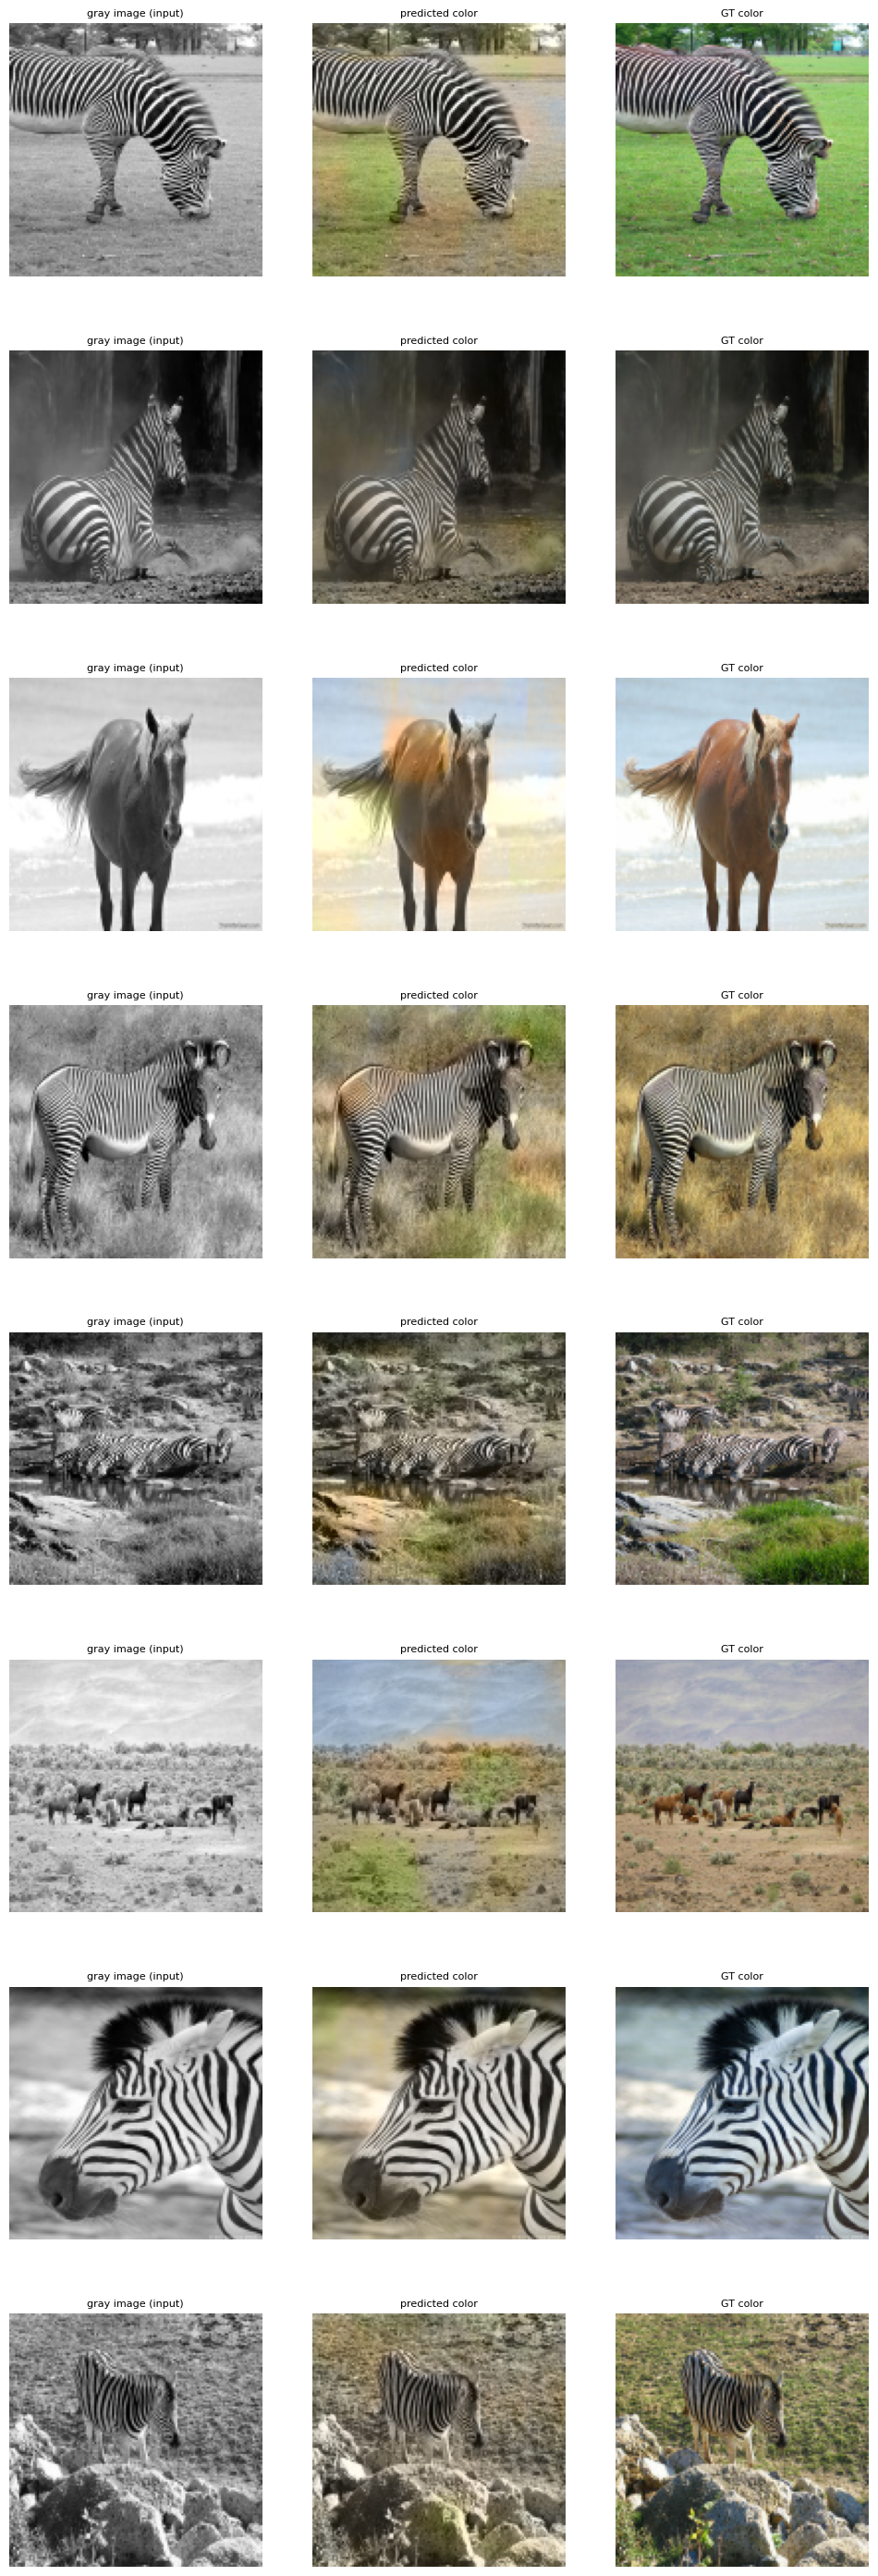

In [11]:
# show sample result of model from the test dataset
sample_input, sample_output = list(ds_test.as_numpy_iterator())[0]
grayimg = sample_input
colorimg = tfio.experimental.color.lab_to_rgb(np.concatenate((100*grayimg,128*sample_output), axis=-1)).numpy()
pred_colorimg = tfio.experimental.color.lab_to_rgb(np.concatenate((100*grayimg,128*model.predict(grayimg, verbose=0)), axis=-1)).numpy()
fig, axs = plt.subplots(8, 3, figsize=(12,36))
for i in range(8):
    axs[i,0].imshow(grayimg[i,...], cmap='gray')
    axs[i,1].imshow(pred_colorimg[i,...])
    axs[i,2].imshow(colorimg[i,...])
    axs[i,0].set_title('gray image (input)', size=8)
    axs[i,1].set_title('predicted color', size=8)
    axs[i,2].set_title('GT color', size=8)
    axs[i,0].axis('off')
    axs[i,1].axis('off')
    axs[i,2].axis('off')
plt.show()